In [1]:
# coding: utf-8
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from skimage import exposure
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split, KFold

2022-03-10 17:11:03.417127: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
img_files = next(os.walk(r"/home/weiweili/notebook/WHJ/images2/image"))[2]
msk_files = next(os.walk(r"/home/weiweili/notebook/WHJ/images2/lable"))[2]

img_files.sort()
msk_files.sort()
print(len(img_files))
print(len(msk_files))

88
88


In [4]:
X = []
Y = []

for img_fl in tqdm(img_files):    
    if(img_fl.split('.')[-1]=='png'):
        img = cv2.imread('/home/weiweili/notebook/WHJ/images2/image/{}'.format(img_fl))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        resized_img = cv2.resize(img,(256, 192), interpolation = cv2.INTER_CUBIC)
        X.append(resized_img)
        
        msk = cv2.imread('/home/weiweili/notebook/WHJ/images2/lable/{}'.format(img_fl.split('.')[0]+'.png'),cv2.IMREAD_GRAYSCALE)
        resized_msk = cv2.resize(msk,(256, 192), interpolation = cv2.INTER_CUBIC)
        Y.append(resized_msk)

100%|██████████████████████████████████████████| 88/88 [00:00<00:00, 338.45it/s]


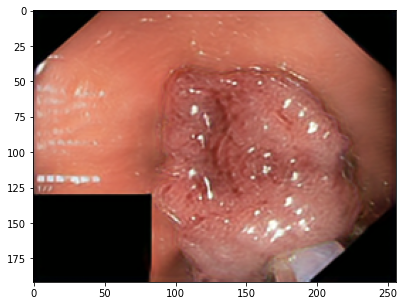

In [5]:
plt.figure(figsize=(10,5))
plt.imshow(resized_img)

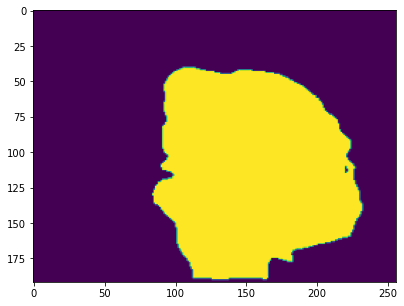

In [6]:
plt.figure(figsize=(10,5))
plt.imshow(resized_msk)

In [7]:
print(len(X))
print(len(Y))

88
88


In [8]:
X = np.array(X)

In [9]:
X

array([[[[ 5,  3,  4],
         [ 0,  1,  0],
         [ 3, 12,  1],
         ...,
         [ 4,  7,  0],
         [ 0,  1,  0],
         [ 0,  3,  0]],

        [[ 8,  0,  0],
         [ 5,  5,  0],
         [12, 16,  9],
         ...,
         [ 5, 11,  0],
         [ 0,  3,  0],
         [ 1,  5,  0]],

        [[ 6,  1,  0],
         [ 4,  2,  1],
         [ 9, 10,  8],
         ...,
         [ 2,  8,  0],
         [ 1,  4,  0],
         [ 9,  8,  3]],

        ...,

        [[ 7, 10,  0],
         [ 0,  5,  0],
         [ 5, 11,  0],
         ...,
         [ 7, 15,  0],
         [ 3,  5,  0],
         [ 6,  6,  0]],

        [[ 0,  7,  0],
         [ 0,  0,  0],
         [ 4,  9,  0],
         ...,
         [ 6, 11,  0],
         [ 0,  0,  0],
         [ 2,  1,  0]],

        [[ 4,  7,  0],
         [ 0,  5,  0],
         [ 5, 10,  0],
         ...,
         [ 5,  6,  0],
         [ 0,  0,  0],
         [ 1,  0,  0]]],


       [[[ 4,  4,  5],
         [ 0,  2,  0],
         [ 3, 

In [10]:
Y = np.array(Y)

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

Y_train = Y_train.reshape((Y_train.shape[0],Y_train.shape[1],Y_train.shape[2],1))
Y_test = Y_test.reshape((Y_test.shape[0],Y_test.shape[1],Y_test.shape[2],1))

X_train = X_train / 255
X_test = X_test / 255
Y_train = Y_train / 255
Y_test = Y_test / 255

Y_train = np.round(Y_train,0)	
Y_test = np.round(Y_test,0)	

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(70, 192, 256, 3)
(70, 192, 256, 1)
(18, 192, 256, 3)
(18, 192, 256, 1)


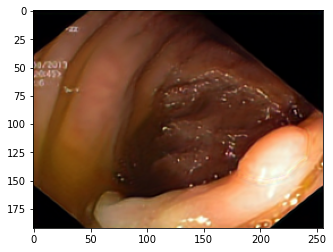

In [12]:
plt.imshow(X_train[0])

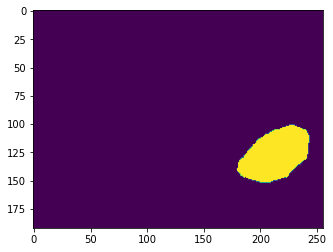

In [13]:
plt.imshow(Y_train[0])

In [14]:
Y_test[0].shape

(192, 256, 1)

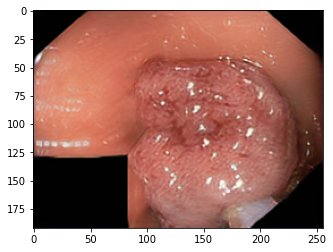

In [15]:
plt.imshow(X_test[0])

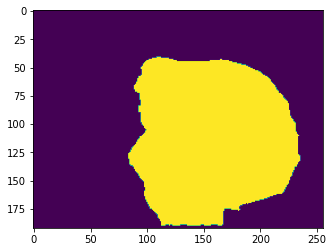

In [16]:
plt.imshow(Y_test[0])

In [17]:
#MDE
def get_kernel():


    k1 = np.array([[1, -3, 1],
                   [-3,  8, -3],
                   [1, -3, 1]])
    
    # Sharpening Spatial Kernel, used in paper
    k2 = np.array([[-1, 0, 1],
                   [-1, 0, 1],
                   [-1, 0, 1]])
    
    k3 = np.array([[-1, -1, -1],
                   [0, 0, 0],
                   [1, 1, 1]])
    
    return k1, k2, k3


def build_MDE_blocks(layer):

    # Get number of channels in the feature
    in_channels = layer.shape[-1]
    # Get kernel
    _, w, _ = get_kernel()    
    # Change dimension
    w = np.expand_dims(w, axis=-1)
    # Repeat filter by in_channels times to get (H, W, in_channels)
    w = np.repeat(w, in_channels, axis=-1)
    # Expand dimension
    w = np.expand_dims(w, axis=-1)
    return w



In [18]:
#Build the Net model
def Net(img_size, num_classes):

    kernel_size = 3

    inputs = Input(img_size)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    
    # Skip connection 1
    # 1. Get sharpening kernel weights(1, H, W, channels) 
    W1 = build_MDE_blocks(conv4)
    # 2. Build depthwise convolutional layer with random weights
    sb1 = DepthwiseConv2D(kernel_size, use_bias=False, padding='same')
    # 3. Pass input to layer
    conv4 = sb1(conv4)
    # 4. Set filters as layer weights 
    sb1.set_weights([W1])
    # 5. Dont update weights
    sb1.trainable = False
    
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    
    # Skip connection 2
    W2 = build_MDE_blocks(conv3) 
    sb2 = DepthwiseConv2D(kernel_size, use_bias=False, padding='same')
    conv3 = sb2(conv3)
    sb2.set_weights([W2])
    sb2.trainable = False
   
    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    # Skip connection 3
    W3 = build_MDE_blocks(conv2) 
    sb3 = DepthwiseConv2D(kernel_size, use_bias=False, padding='same')
    conv2 = sb3(conv2)
    sb3.set_weights([W3])
    sb3.trainable = False
    
    
    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    
    
    # Skip connection 4
    W4 = build_MDE_blocks(conv1)
    sb4 = DepthwiseConv2D(kernel_size, use_bias=False, padding='same')
    conv1 = sb4(conv1)
    sb4.set_weights([W4])
    sb4.trainable = False
    

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    # for multi-class segmentation, use the 'softmax' activation
    conv10 = Conv2D(num_classes, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])    
    
    return model

In [19]:
#custom metrics
smooth = 1

def jacard(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum ( y_true_f * y_pred_f)
    union = K.sum ( y_true_f + y_pred_f - y_true_f * y_pred_f)
    return intersection/union


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [20]:
#modole callback
checkpointer = ModelCheckpoint("model.h5", verbose=0, monitor='val_loss', mode='min', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, min_lr=1e-8, mode='min')

In [21]:


# Build model
model = None
model = Net((192,256,3), 1)
model.summary()

# Compile model 
model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
              metrics = [jacard, dice_coef])

# Train
epochs = 500
his = model.fit(X_train, Y_train,
                batch_size=2,
                epochs=epochs,
                validation_data=(X_test, Y_test),
                callbacks=[reduce_lr, checkpointer],
                shuffle=True)

2022-03-10 17:11:05.351058: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-03-10 17:11:05.360757: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-03-10 17:11:05.360790: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-03-10 17:11:05.361973: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-03-10 17:11:05.363386: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-03-10 17:11:05.363608: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcurand.so

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 192, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 192, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 96, 128, 32)  0           conv2d_1[0][0]                   
_______________________________________________________________________________________

2022-03-10 17:11:07.600134: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2022-03-10 17:11:08.811428: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


35/35 [==============================] - 1s 28ms/step - loss: 0.5770 - jacard: 0.1342 - dice_coef: 0.2331 - val_loss: 0.5411 - val_jacard: 0.1444 - val_dice_coef: 0.2508
Epoch 2/500
35/35 [==============================] - 1s 21ms/step - loss: 0.4769 - jacard: 0.1287 - dice_coef: 0.2264 - val_loss: 0.5114 - val_jacard: 0.1528 - val_dice_coef: 0.2637
Epoch 3/500
35/35 [==============================] - 1s 21ms/step - loss: 0.4704 - jacard: 0.1365 - dice_coef: 0.2384 - val_loss: 0.4858 - val_jacard: 0.1487 - val_dice_coef: 0.2578
Epoch 4/500
35/35 [==============================] - 1s 25ms/step - loss: 0.4403 - jacard: 0.1493 - dice_coef: 0.2577 - val_loss: 0.4791 - val_jacard: 0.1506 - val_dice_coef: 0.2612
Epoch 5/500
35/35 [==============================] - 1s 21ms/step - loss: 0.4211 - jacard: 0.1526 - dice_coef: 0.2628 - val_loss: 0.4624 - val_jacard: 0.1801 - val_dice_coef: 0.3038
Epoch 6/500
35/35 [==============================] - 1s 16ms/step - loss: 0.4185 - jacard: 0.1732 - di

Epoch 46/500
35/35 [==============================] - 1s 22ms/step - loss: 0.0128 - jacard: 0.9571 - dice_coef: 0.9780 - val_loss: 0.0436 - val_jacard: 0.9303 - val_dice_coef: 0.9638
Epoch 47/500
35/35 [==============================] - 1s 17ms/step - loss: 0.0126 - jacard: 0.9571 - dice_coef: 0.9780 - val_loss: 0.0577 - val_jacard: 0.9197 - val_dice_coef: 0.9580
Epoch 48/500
35/35 [==============================] - 1s 17ms/step - loss: 0.0123 - jacard: 0.9596 - dice_coef: 0.9793 - val_loss: 0.0524 - val_jacard: 0.9239 - val_dice_coef: 0.9603
Epoch 49/500
35/35 [==============================] - 1s 16ms/step - loss: 0.0115 - jacard: 0.9613 - dice_coef: 0.9802 - val_loss: 0.0444 - val_jacard: 0.9316 - val_dice_coef: 0.9645
Epoch 50/500
35/35 [==============================] - 1s 16ms/step - loss: 0.0127 - jacard: 0.9587 - dice_coef: 0.9788 - val_loss: 0.0537 - val_jacard: 0.9150 - val_dice_coef: 0.9553
Epoch 51/500
35/35 [==============================] - 1s 16ms/step - loss: 0.0128 - j

Epoch 87/500
35/35 [==============================] - 1s 17ms/step - loss: 0.0089 - jacard: 0.9662 - dice_coef: 0.9827 - val_loss: 0.0467 - val_jacard: 0.9334 - val_dice_coef: 0.9654
Epoch 88/500
35/35 [==============================] - 1s 17ms/step - loss: 0.0089 - jacard: 0.9663 - dice_coef: 0.9828 - val_loss: 0.0467 - val_jacard: 0.9334 - val_dice_coef: 0.9654
Epoch 89/500
35/35 [==============================] - 1s 17ms/step - loss: 0.0089 - jacard: 0.9661 - dice_coef: 0.9827 - val_loss: 0.0467 - val_jacard: 0.9334 - val_dice_coef: 0.9654
Epoch 90/500
35/35 [==============================] - 1s 17ms/step - loss: 0.0089 - jacard: 0.9669 - dice_coef: 0.9831 - val_loss: 0.0467 - val_jacard: 0.9334 - val_dice_coef: 0.9654
Epoch 91/500
35/35 [==============================] - 1s 17ms/step - loss: 0.0089 - jacard: 0.9680 - dice_coef: 0.9837 - val_loss: 0.0467 - val_jacard: 0.9334 - val_dice_coef: 0.9654
Epoch 92/500
35/35 [==============================] - 1s 17ms/step - loss: 0.0089 - j

Epoch 130/500
35/35 [==============================] - 1s 17ms/step - loss: 0.0089 - jacard: 0.9686 - dice_coef: 0.9840 - val_loss: 0.0467 - val_jacard: 0.9335 - val_dice_coef: 0.9654
Epoch 131/500
35/35 [==============================] - 1s 17ms/step - loss: 0.0089 - jacard: 0.9674 - dice_coef: 0.9834 - val_loss: 0.0467 - val_jacard: 0.9335 - val_dice_coef: 0.9654
Epoch 132/500
35/35 [==============================] - 1s 17ms/step - loss: 0.0089 - jacard: 0.9682 - dice_coef: 0.9838 - val_loss: 0.0467 - val_jacard: 0.9335 - val_dice_coef: 0.9654
Epoch 133/500
35/35 [==============================] - 1s 17ms/step - loss: 0.0089 - jacard: 0.9670 - dice_coef: 0.9832 - val_loss: 0.0467 - val_jacard: 0.9335 - val_dice_coef: 0.9654
Epoch 134/500
35/35 [==============================] - 1s 17ms/step - loss: 0.0089 - jacard: 0.9664 - dice_coef: 0.9828 - val_loss: 0.0467 - val_jacard: 0.9335 - val_dice_coef: 0.9654
Epoch 135/500
35/35 [==============================] - 1s 17ms/step - loss: 0.00

35/35 [==============================] - 1s 17ms/step - loss: 0.0089 - jacard: 0.9667 - dice_coef: 0.9830 - val_loss: 0.0468 - val_jacard: 0.9335 - val_dice_coef: 0.9654
Epoch 219/500
35/35 [==============================] - 1s 17ms/step - loss: 0.0089 - jacard: 0.9672 - dice_coef: 0.9833 - val_loss: 0.0468 - val_jacard: 0.9335 - val_dice_coef: 0.9654
Epoch 220/500
35/35 [==============================] - 1s 16ms/step - loss: 0.0089 - jacard: 0.9681 - dice_coef: 0.9838 - val_loss: 0.0468 - val_jacard: 0.9335 - val_dice_coef: 0.9654
Epoch 221/500
35/35 [==============================] - 1s 17ms/step - loss: 0.0089 - jacard: 0.9679 - dice_coef: 0.9837 - val_loss: 0.0468 - val_jacard: 0.9335 - val_dice_coef: 0.9654
Epoch 222/500
35/35 [==============================] - 1s 17ms/step - loss: 0.0089 - jacard: 0.9663 - dice_coef: 0.9829 - val_loss: 0.0468 - val_jacard: 0.9335 - val_dice_coef: 0.9654
Epoch 223/500
35/35 [==============================] - 1s 17ms/step - loss: 0.0089 - jacard: 0

35/35 [==============================] - 1s 17ms/step - loss: 0.0089 - jacard: 0.9666 - dice_coef: 0.9830 - val_loss: 0.0468 - val_jacard: 0.9336 - val_dice_coef: 0.9655
Epoch 307/500
35/35 [==============================] - 1s 17ms/step - loss: 0.0089 - jacard: 0.9670 - dice_coef: 0.9832 - val_loss: 0.0468 - val_jacard: 0.9336 - val_dice_coef: 0.9655
Epoch 308/500
35/35 [==============================] - 1s 17ms/step - loss: 0.0089 - jacard: 0.9661 - dice_coef: 0.9827 - val_loss: 0.0468 - val_jacard: 0.9336 - val_dice_coef: 0.9655
Epoch 309/500
35/35 [==============================] - 1s 17ms/step - loss: 0.0089 - jacard: 0.9670 - dice_coef: 0.9832 - val_loss: 0.0468 - val_jacard: 0.9336 - val_dice_coef: 0.9655
Epoch 310/500
35/35 [==============================] - 1s 17ms/step - loss: 0.0089 - jacard: 0.9662 - dice_coef: 0.9828 - val_loss: 0.0468 - val_jacard: 0.9336 - val_dice_coef: 0.9655
Epoch 311/500
35/35 [==============================] - 1s 17ms/step - loss: 0.0089 - jacard: 0

35/35 [==============================] - 1s 17ms/step - loss: 0.0089 - jacard: 0.9681 - dice_coef: 0.9838 - val_loss: 0.0469 - val_jacard: 0.9336 - val_dice_coef: 0.9655
Epoch 395/500
35/35 [==============================] - 1s 17ms/step - loss: 0.0089 - jacard: 0.9669 - dice_coef: 0.9831 - val_loss: 0.0469 - val_jacard: 0.9336 - val_dice_coef: 0.9655
Epoch 396/500
35/35 [==============================] - 1s 17ms/step - loss: 0.0089 - jacard: 0.9678 - dice_coef: 0.9836 - val_loss: 0.0469 - val_jacard: 0.9336 - val_dice_coef: 0.9655
Epoch 397/500
35/35 [==============================] - 1s 17ms/step - loss: 0.0089 - jacard: 0.9655 - dice_coef: 0.9824 - val_loss: 0.0469 - val_jacard: 0.9336 - val_dice_coef: 0.9655
Epoch 398/500
35/35 [==============================] - 1s 17ms/step - loss: 0.0089 - jacard: 0.9659 - dice_coef: 0.9826 - val_loss: 0.0469 - val_jacard: 0.9336 - val_dice_coef: 0.9655
Epoch 399/500
35/35 [==============================] - 1s 16ms/step - loss: 0.0089 - jacard: 0

35/35 [==============================] - 1s 17ms/step - loss: 0.0089 - jacard: 0.9661 - dice_coef: 0.9827 - val_loss: 0.0469 - val_jacard: 0.9337 - val_dice_coef: 0.9656
Epoch 483/500
35/35 [==============================] - 1s 17ms/step - loss: 0.0089 - jacard: 0.9684 - dice_coef: 0.9839 - val_loss: 0.0469 - val_jacard: 0.9337 - val_dice_coef: 0.9656
Epoch 484/500
35/35 [==============================] - 1s 17ms/step - loss: 0.0089 - jacard: 0.9673 - dice_coef: 0.9833 - val_loss: 0.0469 - val_jacard: 0.9337 - val_dice_coef: 0.9656
Epoch 485/500
35/35 [==============================] - 1s 17ms/step - loss: 0.0089 - jacard: 0.9676 - dice_coef: 0.9835 - val_loss: 0.0469 - val_jacard: 0.9337 - val_dice_coef: 0.9656
Epoch 486/500
35/35 [==============================] - 1s 17ms/step - loss: 0.0089 - jacard: 0.9660 - dice_coef: 0.9827 - val_loss: 0.0469 - val_jacard: 0.9337 - val_dice_coef: 0.9656
Epoch 487/500
35/35 [==============================] - 1s 17ms/step - loss: 0.0089 - jacard: 0

In [22]:
history = his.history
loss = history['loss']
jacard = history['jacard']
dice_coef = history['dice_coef']
val_loss = history['val_loss']
val_jacard = history['val_jacard']
val_dice_coef = history['val_dice_coef']

In [23]:
df = pd.DataFrame(history)
df.to_csv('/home/weiweili/notebook/WHJ/params2/unet+mde_histtory.csv')


In [24]:
# Evaluatete
# Evaluate trained model using Jaccard and Dice metric
yp = model.predict(x=X_test, batch_size=2, verbose=0)
# Round off boolean masks
yp = np.round(yp, 0)

In [25]:
jacard = 0
dice = 0
sen = 0
pre = 0
jsc = 0
mmc = 0

for i in range(len(Y_test)):
    yp_2 = yp[i].ravel()
    y2 = Y_test[i].ravel()
    intersection = yp_2 * y2
    union = yp_2 + y2 - intersection
    jacard += (np.sum(intersection) / np.sum(union))
    dice += (2. * np.sum(intersection)) / (np.sum(yp_2) + np.sum(y2))
    TP = np.sum(yp_2 * y2)
    TN = np.sum((1-yp_2) * (1-y2))
    FP = np.sum(yp_2 * (1-y2))
    FN = np.sum(y2 * (1-yp_2))
    sen += TP/(TP+FN)
    pre += TP/(TP+FP)
    jsc += TP/(TP+FN+FP)
    mmc += (TP*TN-FP*FN)/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))


In [26]:
jacard /= len(Y_test)
dice /= len(Y_test)
sen /= len(Y_test)
pre /= len(Y_test)
jsc /= len(Y_test)
mmc /= len(Y_test)

print('Jacard Index : ' + str(jacard))
print('Dice Coefficient : ' + str(dice))
print('sen : ' + str(sen))
print('pre : ' + str(pre))
print('jsc : ' + str(jsc))
print('mmc : ' + str(mmc))

Jacard Index : 0.935935591889227
Dice Coefficient : 0.9658544970231865
sen : 0.9646684531884018
pre : 0.9680953308255423
jsc : 0.935935591889227
mmc : 0.9574853567347095


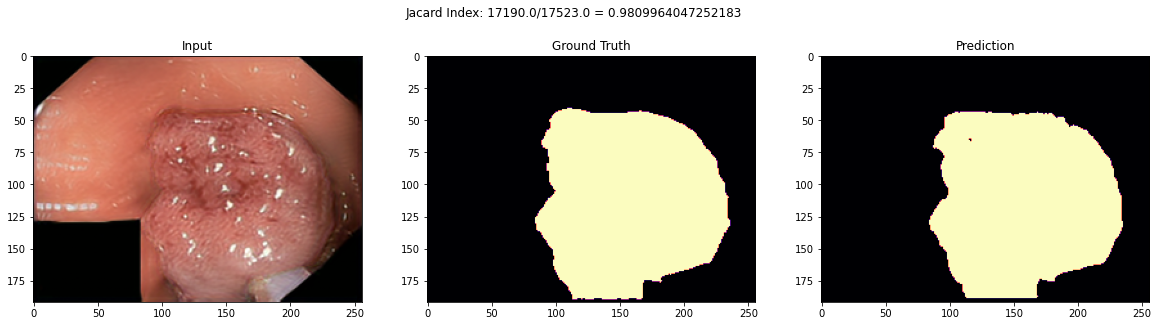

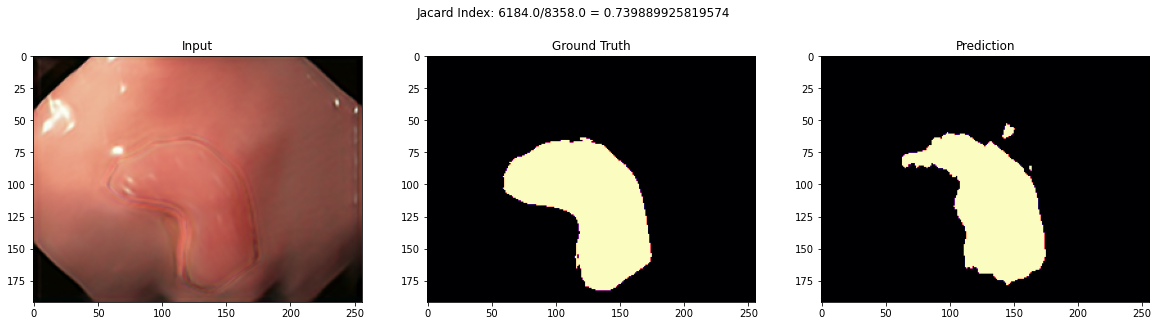

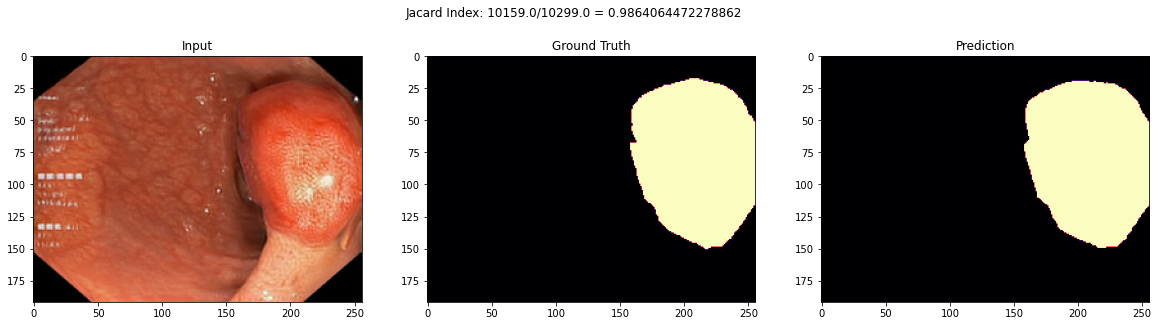

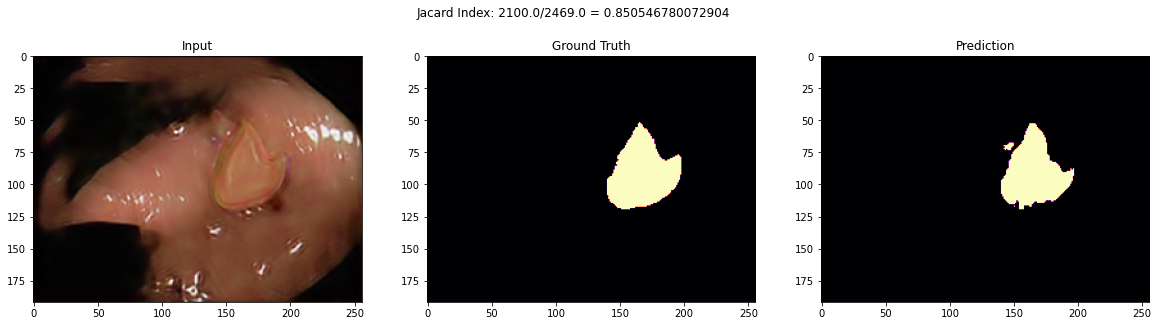

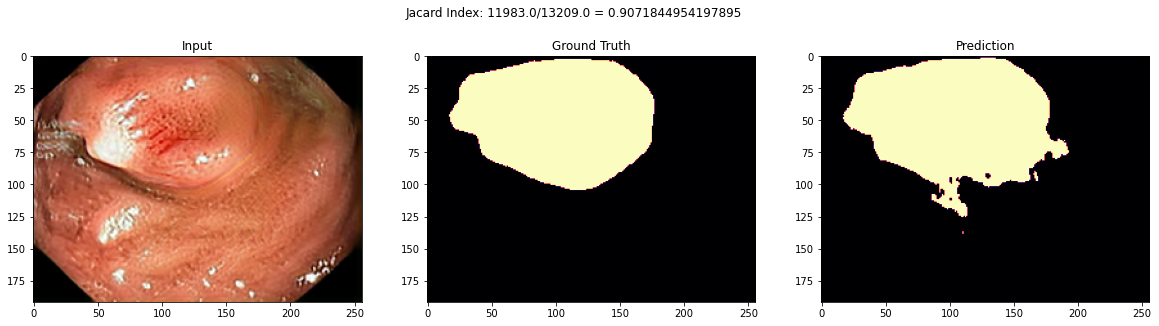

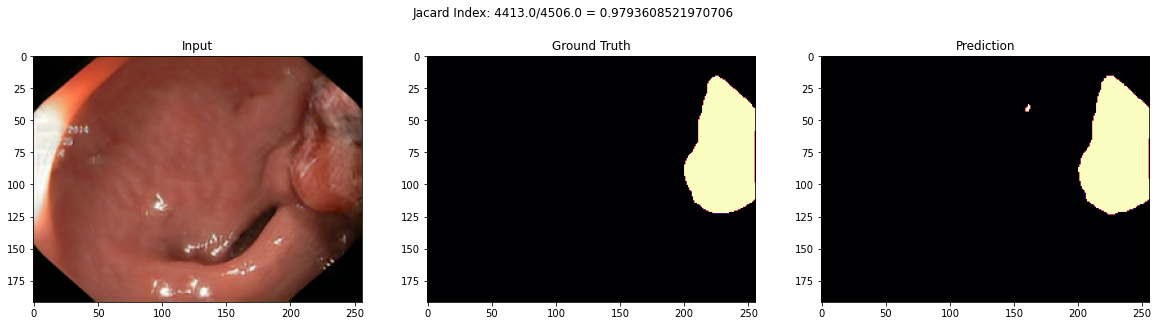

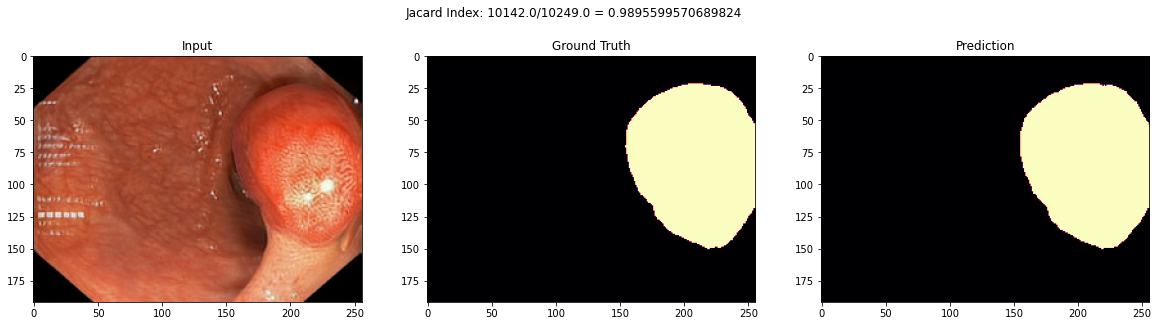

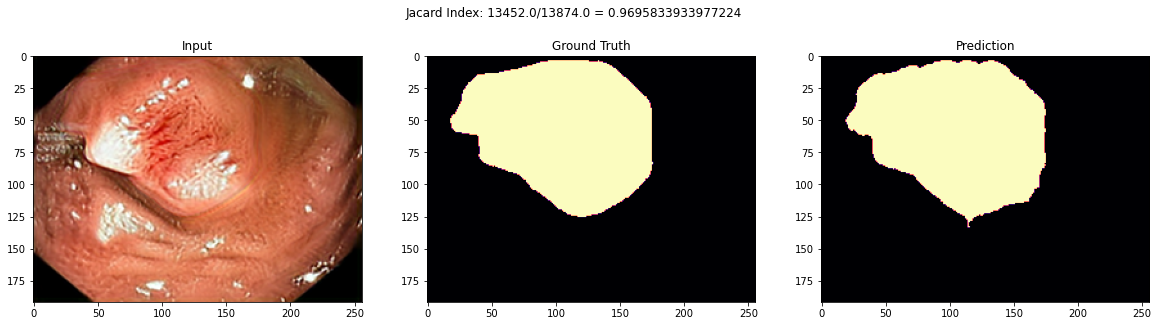

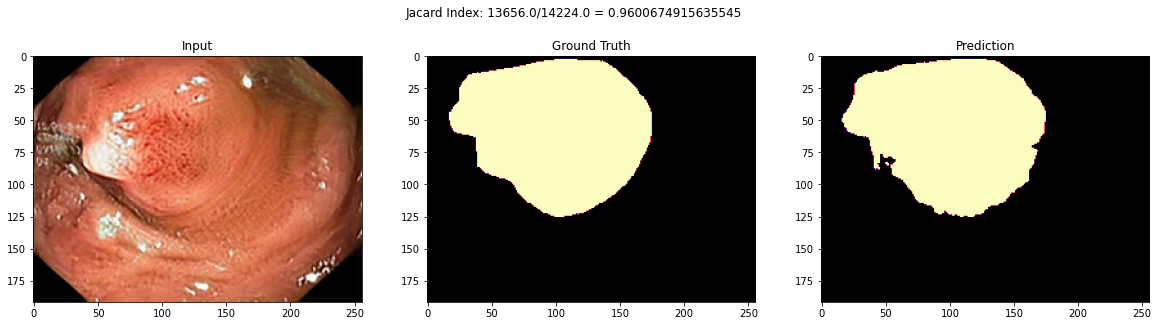

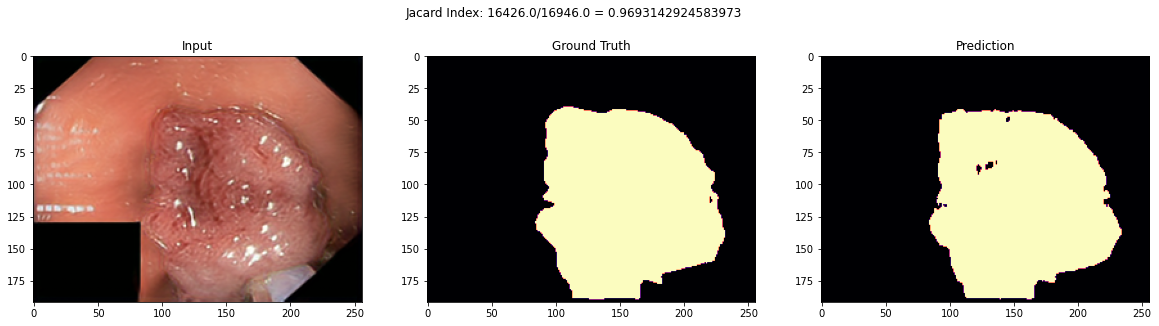

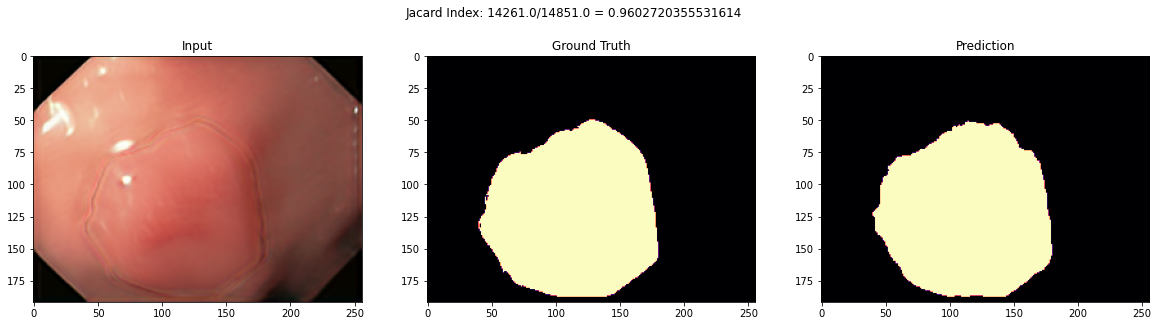

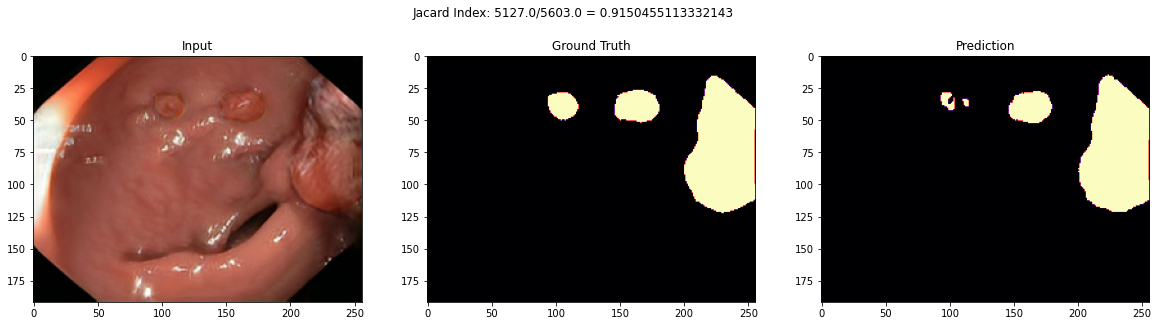

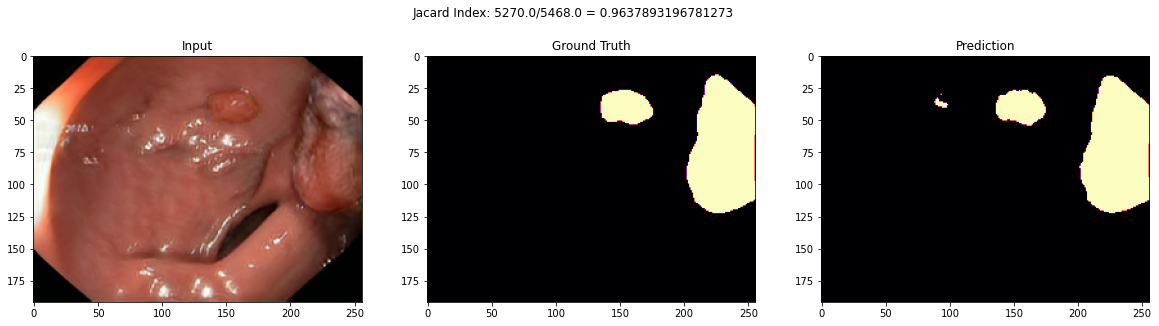

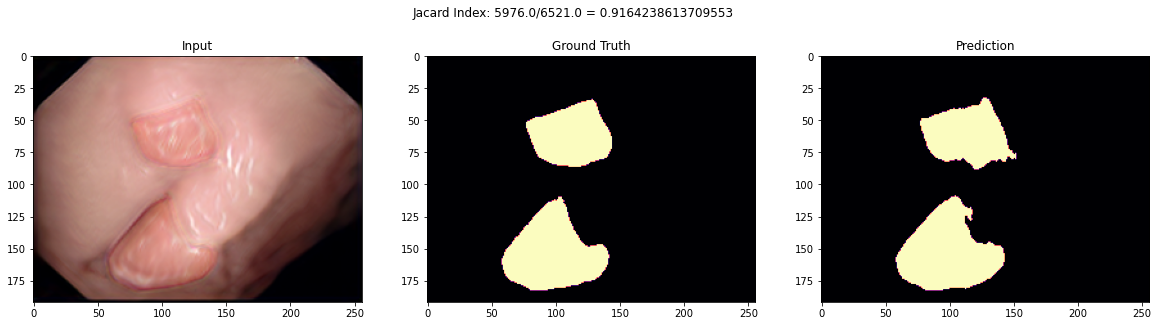

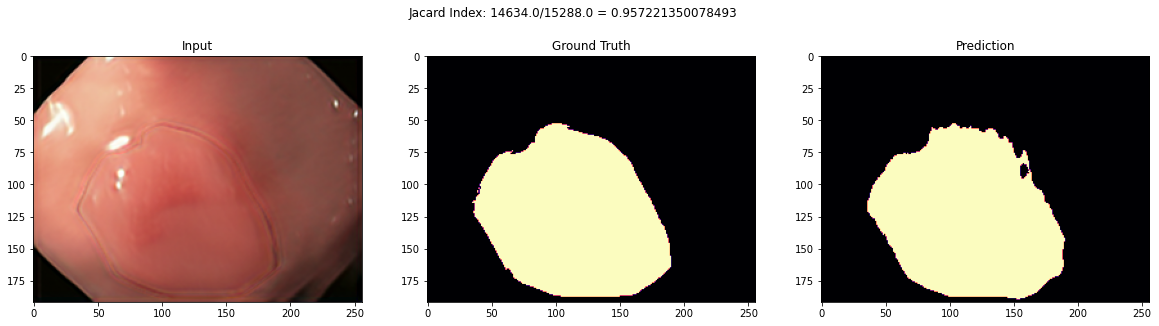

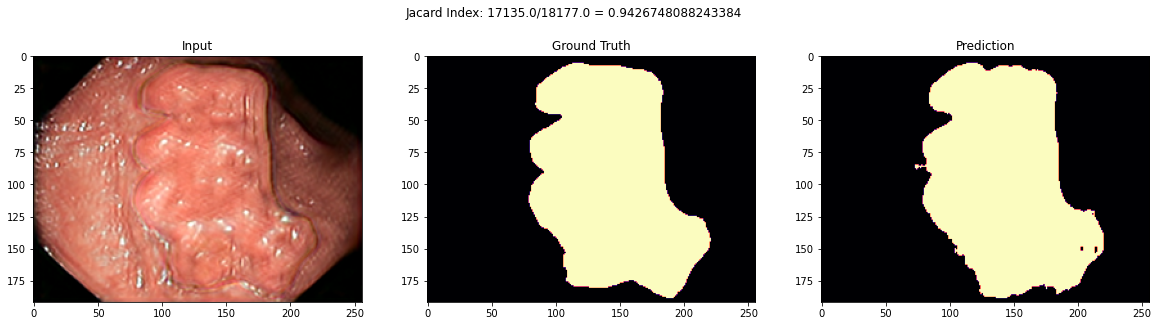

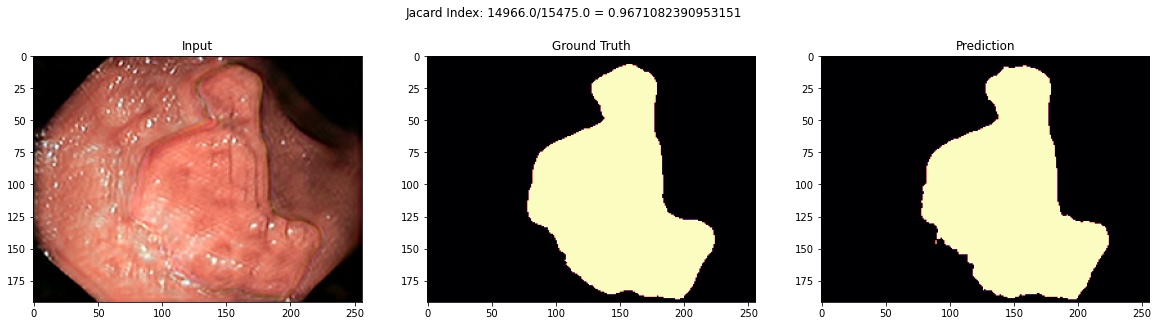

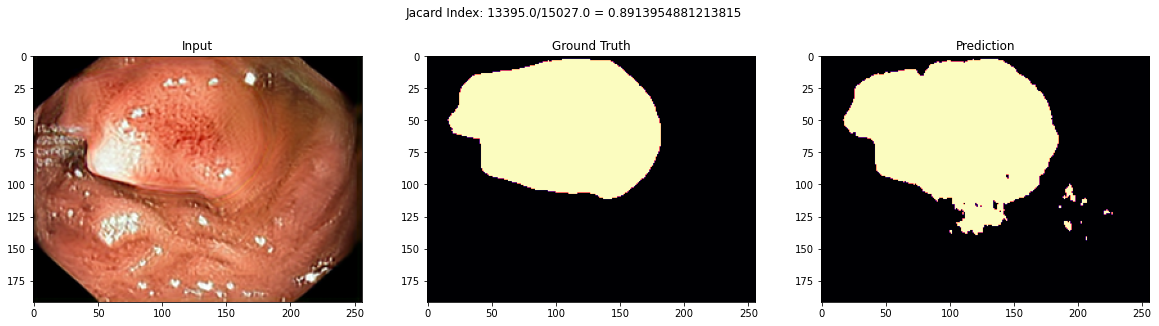

IndexError: index 18 is out of bounds for axis 0 with size 18

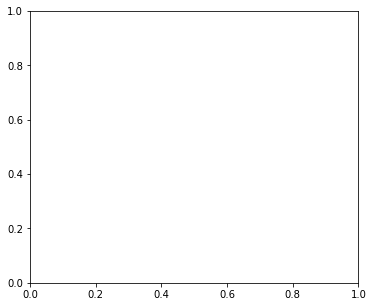

In [27]:
os.makedirs('unet+mde_res', exist_ok=True)
for i in range(20):
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 3, 1)
    if len(X_test[i].shape) >= 2:
        plt.grid(False)
        plt.imshow(X_test[i].squeeze(), cmap='gray')  # 1-channel image
    else:
        plt.grid(False)
        plt.imshow(X_test[i])  # 3-channel

    plt.title('Input')
    plt.subplot(1, 3, 2)
    plt.grid(False)
    plt.imshow(Y_test[i].reshape(Y_test[i].shape[0], Y_test[i].shape[1]), cmap='magma')  # cmap='magma'
    plt.title('Ground Truth')
    plt.subplot(1, 3, 3)
    plt.grid(False)
    plt.imshow(yp[i].reshape(yp[i].shape[0], yp[i].shape[1]), cmap='magma')
    plt.title('Prediction')

    # Calc jaccard index of predictions
    intersection = yp[i].ravel() * Y_test[i].ravel()
    union = yp[i].ravel() + Y_test[i].ravel() - intersection
    jacard = (np.sum(intersection) / np.sum(union))

    plt.suptitle('Jacard Index: ' + str(np.sum(intersection)) + '/' + str(np.sum(union)) + ' = ' + str(jacard))
    plt.savefig(r"/home/weiweili/notebook/WHJ/params2/unet+mde_res/test_%d.tif"%(i))
    plt.show()


In [ ]:
X = np.array(X)
Y = np.array(Y)
Y = Y.reshape((Y.shape[0], Y.shape[1], Y.shape[2], 1))
X = X / 255
Y = Y / 255
Y = np.round(Y, 0)
X = exposure.adjust_gamma(X, 1.5)

In [ ]:
kf = KFold(n_splits=5)
k=0

In [ ]:
for train_index, test_index in kf.split(X):
    k+=1
    X_train = X[train_index]
    Y_train = Y[train_index]
    X_test = X[test_index]
    Y_test = Y[test_index]

    def jacard(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        union = K.sum(y_true_f + y_pred_f - y_true_f * y_pred_f)
        return intersection / union

    def dice_coef(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    model = SharpUNet((192, 256, 3), 1)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[jacard, dice_coef])
    epochs = 500
    his = model.fit(X_train, Y_train,
          batch_size=2,
          epochs=epochs,
          validation_data=(X_test, Y_test),
          callbacks=[reduce_lr],
          shuffle=True)
    history = his.history
    df = pd.DataFrame(history)
    df.to_csv('/home/weiweili/notebook/WHJ/params2/1_unet+mde-histtory_%d.csv'% (k))
    yp = model.predict(x=X_test, batch_size=2, verbose=0)
    yp = np.round(yp, 0)
    jacard = 0
    dice = 0
    sen = 0
    pre = 0
    jsc = 0
    mmc = 0

    for i in range(len(Y_test)):
        yp_2 = yp[i].ravel()
        y2 = Y_test[i].ravel()
        intersection = yp_2 * y2
        union = yp_2 + y2 - intersection
        jacard += (np.sum(intersection) / np.sum(union))
        dice += (2. * np.sum(intersection)) / (np.sum(yp_2) + np.sum(y2))
        TP = np.sum(yp_2 * y2)
        TN = np.sum((1 - yp_2) * (1 - y2))
        FP = np.sum(yp_2 * (1 - y2))
        FN = np.sum(y2 * (1 - yp_2))
        sen += TP / (TP + FN)
        pre += TP / (TP + FP)
        jsc += TP / (TP + FN + FP)
        mmc += (TP * TN - FP * FN) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))

    jacard /= len(Y_test)
    dice /= len(Y_test)
    sen /= len(Y_test)
    pre /= len(Y_test)
    jsc /= len(Y_test)
    mmc /= len(Y_test)

    print("%d-th fold verification:" % (k))
    print('Jacard Index : ' + str(jacard))
    print('Dice Coefficient : ' + str(dice))
    print('sen : ' + str(sen))
    print('pre : ' + str(pre))
    print('jsc : ' + str(jsc))
    print('mmc : ' + str(mmc))

print('ok')
